# Training a tabular fast.ai NN for stock signal generation

### we train a GRU + Linear network on a dataset of OHLCV, technical indicators, and trading signals

In [5]:
from TechnicalIndicators import sma, ema, macd, bollinger_bands, obv
from labeltool import LabelTool

from pathlib import Path
from datetime import datetime
import pandas as pd

### Load up OHLCV data, create technical indicators for the data and trim dataset_df 

            time    open    high     low   close  volume       ema10  \
26  1.546441e+09  155.20  155.37  155.12  155.35    1517  829.250597   
27  1.546441e+09  155.14  155.31  155.14  155.19    1474  833.617761   
28  1.546441e+09  155.23  155.32  155.22  155.25    1750  837.280896   
29  1.546441e+09  155.18  155.23  155.09  155.19    1364  840.228005   
30  1.546441e+09  155.14  155.14  154.79  154.79    1493  842.599277   

          ema20        ema50     sma10     sma20     sma50        macd   obv  \
26   896.575247   896.575247  154.7935  154.7935  154.7935  638.630828  4235   
27   966.327129   966.327129  154.8290  154.8290  154.8290  516.528375  2761   
28  1029.525974  1029.525974  154.8400  154.8400  154.8400  402.601856  4511   
29  1086.655881  1086.655881  154.8540  154.8540  154.8540  296.372112  3147   
30  1138.304845  1138.304845  154.8815  154.8815  154.8815  197.387189  1654   

    bb10_low    bb10_mid     bb10_up  bb20_low    bb20_mid     bb20_up  
26   154.908 

ValueError: too many values to unpack (expected 2)

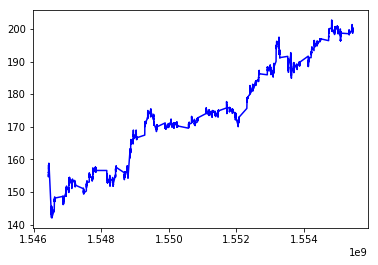

In [9]:
data_path = Path('../hismindata_stock/NASDAQ/')
datasets = ['AAPL.csv',]

for dataset in datasets:
    dataset_path = data_path / dataset
    dataset_df = pd.read_csv(dataset_path)
    
    # Format dataset into 
    dataset_df = dataset_df[['date', 'minute', 'label', 'open', 'high', 'low', 'close', 'volume']].copy()
    
    # TODO Either deal with missing data - or ignore it and see if results remain unaffected
    
    # Convert date minute label columns into one columns, time. 
    timestamps = []
    for index, row in dataset_df.iterrows():
        f = str(row.date) + '|' + row.minute
        timestamp = datetime.timestamp(datetime.strptime(f, '%Y%m%d|%H:%M'))
        timestamps.append(timestamp)
    
    # Add the time column and remove the redundent columns
    dataset_df['time'] = timestamps
    dataset_df = dataset_df[['time', 'open', 'high', 'low', 'close', 'volume']]
    
    ##############################################################################
    
    # Create Technical Indicators for dataset_df
    price_df = dataset_df.open
    volume_df = dataset_df.volume

    ema10_list = ema(price_df.tolist(), n=10)
    ema20_list = ema(price_df.tolist(), n=20)
    ema50_list = ema(price_df.tolist(), n=20)

    sma10_list = sma(price_df.tolist(), n=20)
    sma20_list = sma(price_df.tolist(), n=20)
    sma50_list = sma(price_df.tolist(), n=20)

    bb10 = bollinger_bands(price_df.tolist(), 10, mult=2)
    bb10_low = [x[0] for x in bb10]
    bb10_mid = [x[1] for x in bb10]
    bb10_up = [x[2] for x in bb10]

    bb20 = bollinger_bands(price_df.tolist(), 20, mult=2)
    bb20_low = [x[0] for x in bb20]
    bb20_mid = [x[1] for x in bb20]
    bb20_up = [x[2] for x in bb20]

    macd_list = macd(price_df.tolist())

    obv_list = obv(volume_df.tolist(), price_df.tolist())
    
    # We have indicators for a recent slice of data, so we cut out previous candlesticks
    
    ti_dict = {'ema10': ema10_list, 'ema20': ema20_list, 'ema50': ema50_list, 'sma10': sma10_list,
          'sma20': sma20_list, 'sma50': sma50_list, 'macd': macd_list, 'obv': obv_list,
          'bb10_low': bb10_low, 'bb10_mid': bb10_mid, 'bb10_up': bb10_up, 'bb20_low': bb20_low,
          'bb20_mid': bb20_mid, 'bb20_up': bb20_up}
    l = ''
    c = 100 ** 10
    for label, data in ti_dict.items():
        if len(data) < c:
            l, c = label, len(data)
    
    # First cut down our TI's
    for label, data in ti_dict.items():
        cut_amount = len(data) - len(macd_list)
        ti_dict[label] = data[cut_amount:]  
        
    # Next cut down our dataset_df
    dataset_df = dataset_df.iloc[dataset_df.shape[0]-len(macd_list):]
    dataset_df.shape[0]
    
    # Add data
    for label, data in ti_dict.items():
        dataset_df[label] = data
        
    print(dataset_df.head())
    
    ##############################################################################################
    
    # Format Technical Indicators used in plotting into dictionary {color : [(x1, y1), (x2, y2), (x3, y3)]
    
    bb_points = []
    sma_points = []
    
    for index, row in dataset_df.iterrows():
        time = row['time']
        bb_points += [(time, row['bb10_low']), (time, row['bb10_mid']), (time, row['bb10_up'])]
        sma_points += [(time, row['sma10'])]
    
    tech_inds = {'pink': bb_points, 'yellow': sma_points}
    
    ###############################################################################################
    
    # Run our labelling software to hand label buy and sell points on each dataset_df
    col_label = 'time'
    row_label = 'open'
    csv_path = dataset[:-3] + '_labels.csv'
    tool = LabelTool(dataset_df, col_label, row_label, csv_path, tech_inds=tech_inds)
    tool.show_chart()

### Format Technical Indicators into dictionary {color : [(x1, y1), (x2, y2), (x3, y3)]

### Use our labelling tool to hand-label all buy and sell signals for each dataset

### Concatenate DataFrame side-by-side

### Save it for training